In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from mppi import Parsers as P, Utilities as U
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
from mppi.Utilities import Dos
from mppi.Utilities.Parallel import loop

from scipy.integrate import odeint, simps
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = C.Planck_ev_ps*1e3 # h in eV*fs

# TLS for short weak pulses in the extended k-sampling region

We compare the RT results with a TLS (non-perturbative) solution. 

We set the property of the pulses and read the parameter of the system

In [3]:
# analysis with k-sampling in the large volue 0.06
ref_run_dir = 'PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm'
#ref_outpath = 'PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e4_1e4-omega_1.58-fwhm_10/'
ref_outpath = 'PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/'

In [4]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.external_field
Parse file PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.polarization
Parse file PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.carriers
Parse file PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/o-100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10.current
Parse file : PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/100fs-direct-int_1e7_1e7-omega_1.58-fwhm_10/ndb.RT_G_PAR


In [5]:
fwhm = 10 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
energy = 1.58 # eV energy of the pulse
#int1, int2 = 1e4, 1e4 # intensity of the pulses in kW/cm^2
int1, int2 = 1e7, 1e7 # intensity of the pulses in kW/cm^2
eta = 4e-3 # decay constant in fs^-1
omega = energy/h_red # angular frequency of the pulse
period = h/energy # period of the pulse fs
width = fwhm/(2.*np.sqrt(2.*np.log(2.))) # width of the pulse in term of the fwhm

### Computation of the dipoles, transition energies and detunings

We compute the module of the x component of the dipoles for each k point.

In [6]:
trans_dipoles = abs(ref_results.dipoles.r_dipole(0))
nk = len(trans_dipoles)
nk

11985

The array trans_dipoles has the index structure [kpoint,band,band] so in the present case
[kpoint,v,3] with v from 0 to 2 (the lowest full band is not included in this array so that there are three full bands) 
gives the transition dipole (x component) of the valence conduction couples associated to the point k

The array with the detunings and the associated dipoles can be built as follows

__Include all the transition inside a given energy with respect to the pump__

We extract all the transition energies, and associated dipoles, that are inside a given energy range
respect to the pump energy.

In [7]:
pump_width = 0.25 # eV it gives the range of the abs of the field spread. So the acceptance range is twice this value

In [8]:
ref_results.dft.get_transitions(initial=[1,2,3],final=[4],set_scissor=scissor)[0]

array([1.42010708, 1.42010708, 1.42010708])

In [9]:
de_cv= []
mu = []
dip_ind = {0:[0,3],1:[1,3],2:[2,3]} # index referred to the rt_bands
all_trans = ref_results.dft.get_transitions(initial=[1,2,3],final=[4],set_scissor=scissor)
for k in range(nk):
    spread = np.abs(all_trans[k] - energy)
    for ind,t in enumerate(spread):
        if t <= pump_width:
            de_cv.append(all_trans[k][ind])
            mu.append(trans_dipoles[k,dip_ind[ind][0],dip_ind[ind][1]])
de_cv = np.array(de_cv)
mu = np.array(mu)
delta = omega - de_cv/h_red
kvalues = np.array([k for k in range(len(delta))])
numk = len(kvalues)
numk

34875

In [10]:
numk/nk

2.909887359198999

In [11]:
theta1, theta2 = [],[]
for k in kvalues:
    theta1.append(TLS.pulseParametersFromIntensity(mu[k],int1,fwhm=10,verbose=False)['theta'])
    theta2.append(TLS.pulseParametersFromIntensity(mu[k],int2,fwhm=10,verbose=False)['theta'])
theta1,theta2 = np.array(theta1),np.array(theta2)

In [12]:
min(theta1),max(theta1),np.mean(theta1)

(0.0007184734685641202, 5.515478753948375, 1.746638291523616)

In [13]:
np.mean(theta1*theta2**2)/(4*np.mean(theta1))

2.0756264386831567

For computational reasons we can use only a subset of these values

In [14]:
#k_short = 10000
#delta = delta[0:k_short]
#mu = mu[0:k_short]
#kvalues = np.array([k for k in range(len(delta))])
#numk = len(kvalues)
#numk

10000

In [13]:
dos = U.Dos()
dos.append(theta1,minVal=0,maxVal=6,eta=8e-3)

In [14]:
areas = dos.dos[0][0]
values = dos.dos[0][1]

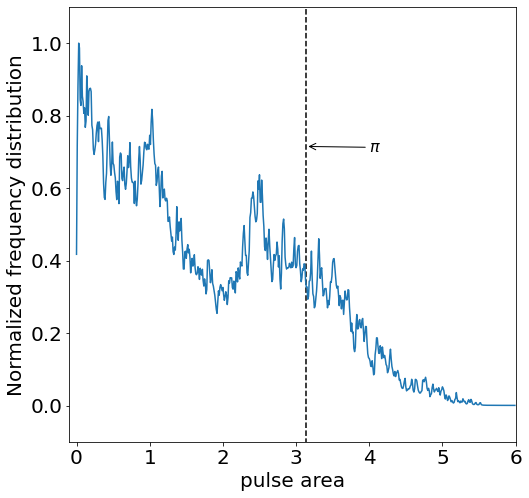

In [18]:
label_size = 20

fig,ax1 = plt.subplots(figsize=(8,8))
dos.plot(plt,legend=False,rescale=True)
#ax1.plot(values,areas)
ax1.set_xlabel('pulse area',size=label_size)
ax1.set_ylabel('Normalized frequency distribution',size=label_size)
ax1.vlines(x=3.14,ymin=-0.5,ymax=1.2,colors='black',linestyle='--')
ax1.annotate('$\pi$', xy=(3.14, 0.715), xytext=(4,0.7),size=16,arrowprops=dict(facecolor='black',arrowstyle='->'),)
ax1.set_ylim(-0.1,1.1)
ax1.set_xlim(-0.1,6)
ax1.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='PHOTON_ECO/Plot/rabi_coupling.eps',format='eps',bbox_inches = "tight")
#plt.savefig(fname='PHOTON_ECO/Plot/fig6.eps',format='eps',bbox_inches = "tight")

### Analysis of the echo peak from the non-perturbative solution

We define the time sampling

In [14]:
NETime = 350 # fs length of the simulation
ntimes = int(NETime) # 1 point each 1 fs
time = np.linspace(0,NETime,ntimes+1)

tau = 100 # time shift in fs

In [15]:
# Definition of the function that computes the Bloch vector for a single k
def eval_u(k,time=time,delta=delta,dipole=mu,intensity1=int1,intensity2=int2,
           energy=energy,fwhm1=fwhm,fwhm2=fwhm,eta=eta,**kwargs):
    u0 = np.array([0.,0.,1.])
    O1 = TLS.pulseParametersFromIntensity(dipole[k],intensity1,fwhm=fwhm1,verbose=False)['Omega0']
    O2 = TLS.pulseParametersFromIntensity(dipole[k],intensity2,fwhm=fwhm2,verbose=False)['Omega0']
    Omega = lambda t : G.doubleGaussianPulse(t,amplitude1=O1,amplitude2=O2,energy=energy, \
                fwhm1=fwhm1,fwhm2=fwhm2,envelope_only=True,verbose=False,**kwargs)
    u = TLS.solveBlochEq_Real(u0,time,Omega,delta=delta[k],eta=eta)
    return u

r = loop(eval_u,kvalues,ntasks=4,t_start2=tau)
u_np = np.transpose(r,axes=[1,2,0])
r = loop(eval_u,kvalues,ntasks=4,t_start2=tau,change_sign2=True)
u_np_inverse = np.transpose(r,axes=[1,2,0])
r = loop(eval_u,kvalues,ntasks=4,intensity2=0,t_start2=tau)
u_np_0 = np.transpose(r,axes=[1,2,0])

Run a parallel loop with 4 tasks...
Loop executed in 00:06:23
Run a parallel loop with 4 tasks...
Loop executed in 00:06:30
Run a parallel loop with 4 tasks...
Loop executed in 00:05:28


We analyze the time behavior of the carriers for some selected k

time unit: fs
the width parameter of the pulse is 4.2466090014400955 fs
Rabi coupling (fs^-1): 0.4258529138623977
Rabi coupling (module) (fs^-1): 0.4258529138623977
field amplitude (V/m): 194095418.0293806
pulse area : 4.533063819352092


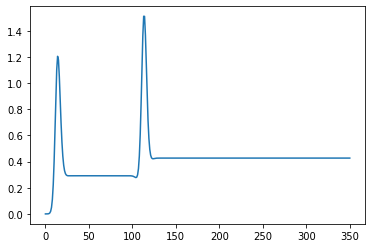

In [16]:
ksel = 2 #2,3
TLS.pulseParametersFromIntensity(mu[ksel],int1,fwhm=fwhm,verbose=True)
plt.plot(time,1-u_np[2,:,ksel])

We observe population inversion at intermediate occupation level

In [102]:
u0 = np.array([0.,0.,1.])
fwhm = 10
O1 = TLS.pulseParametersFromTheta(mu[ksel],0.5*np.pi,fwhm=fwhm)['Omega0']
O2 = 2*O1
Omega = lambda t : G.doubleGaussianPulse(t,amplitude1=O1,amplitude2=O2,energy=energy, \
                fwhm1=fwhm,fwhm2=fwhm,envelope_only=True,t_start2=100,verbose=False)
u = TLS.solveBlochEq_Real(u0,time,Omega,delta=0*delta[ksel],eta=0*eta)
cc = 1-u[2]
max(cc)

time unit: fs
the width parameter of the pulse is 4.2466090014400955 fs
Rabi coupling (fs^-1): 0.14756646266356058
Rabi coupling (module) (fs^-1): 0.14756646266356058
field amplitude (V/m): 67257903.66918944
field intensity (kW/cm^2) : 1200759.6548181048


1.9996229895094113

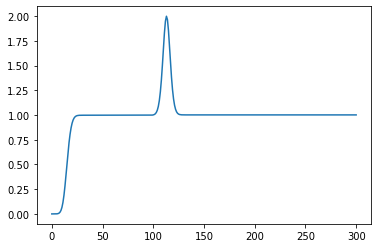

In [103]:
plt.plot(time,1-u[2])

In [23]:
carr = 0.5*np.mean(1-u_np[2],axis=1)

In [24]:
lat_vol = ref_results.dft.eval_lattice_volume()
lat_vol

294.0614899039999

In [25]:
echo = 0.5*(u_np[0]+u_np_inverse[0])-u_np_0[0]
mu_np = np.mean(u_np[0]*mu,axis=1)/lat_vol
mu_echo = np.mean(echo*mu,axis=1)/lat_vol

We compare the TLS results with the RT ones

In [17]:
ref_time = ref_results.data['carriers']['time']
ref_carriers = ref_results.data['carriers']['dne']
ref_px = ref_results.data['polarization']['Pol_x']

In [18]:
#rt_echo_file = 'PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e4_1e4_omega_1.58-fwhm_10.yaml'
rt_echo_file = 'PHOTON_ECO/RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e7_1e7_omega_1.58-fwhm_10.yaml'

In [19]:
with open(rt_echo_file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [20]:
ref_echo_time = np.array(data_loaded['time'])
ref_echo = np.array(data_loaded['echo']['100fs'])

In [21]:
#rescale = ref_carriers[-1]/carr[-1]
rescale = 2*numk/nk
rescale

5.819774718397998

(50.0, 350.0)

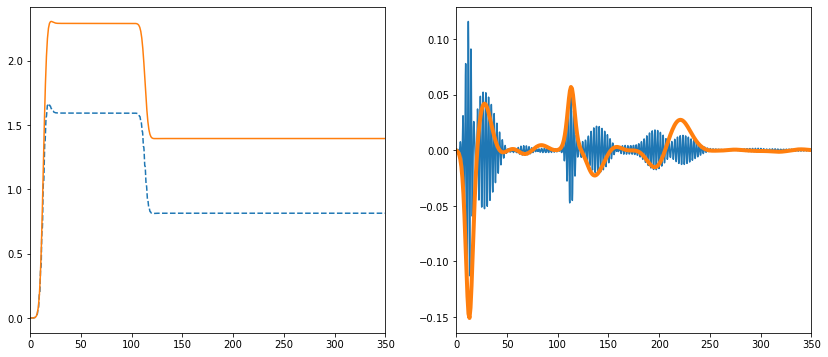

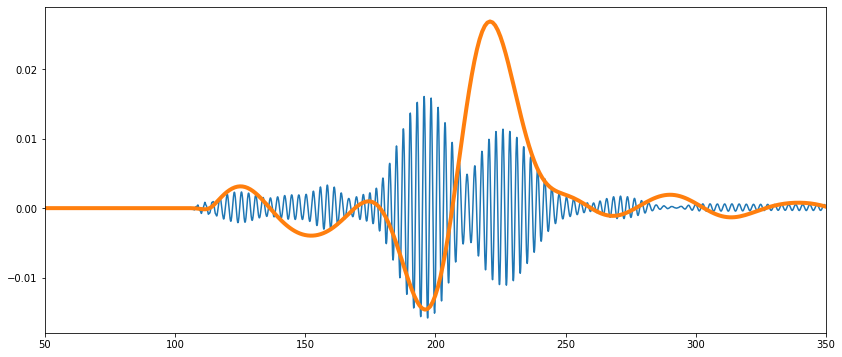

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6))
ax1.plot(ref_time,ref_carriers,linestyle='--')
ax1.plot(time,rescale*carr)
ax1.set_xlim(0,350)
ax2.plot(ref_time,ref_px)
ax2.plot(time,rescale*mu_np,linewidth=4)
ax2.set_xlim(0,350)

plt.figure(figsize=(14,6))
plt.plot(ref_echo_time,ref_echo)
plt.plot(time,1.0*rescale*mu_echo,linewidth=4)
plt.xlim(50,350)

We save relevant data on file

In [28]:
out = {}
out['time'] = time.tolist()
out['carriers'] = carr.tolist()
out['px'] = mu_np.tolist()
out['echo'] = mu_echo.tolist()

In [29]:
import os, yaml
#file_name = 'int_1e4-omega_1.58-fwhm_10.yaml'
file_name = 'int_1e7-omega_1.58-fwhm_10.yaml'
file = os.path.join('PHOTON_ECO','TLS_Results',file_name)
print('save on file %s'%file)
with open(file, 'w') as f:
    yaml.dump(out,f,default_flow_style=False)    

save on file PHOTON_ECO/TLS_Results/int_1e7-omega_1.58-fwhm_10.yaml
